# Import

In [1]:
# Given
# -----
# N : integer, number of neurons.
# K : integer, number of trials.
# C : integer, number of stimulus conditions.
# seed : integer, random seed for reproducibility.
# sigma_m : float, prior kernel smoothness.

# Create instances of prior and likelihood distributions and generate some synthetic data.
import sys
import jax
from numpyro import optim
jax.config.update('jax_enable_x64', True)  # Use float64
jax.config.update("jax_default_matmul_precision", "highest")
# sys.path.append('wishart-process')
import inference
import models
import visualizations
import evaluation
import utils

import jax.numpy as jnp
import numpyro
import matplotlib.pyplot as plt

import itertools
from tqdm import tqdm
import numpy as np
from scipy.io import loadmat

In [2]:
#import data
SATED_DECONV = np.load('../Data/predictions_fullTrace_sated.npy', allow_pickle=True)
ANG_STIM_DATA = loadmat('../Data/metadata_deconv/stimAngle_sated.mat', simplify_cells=True)
SF_STIM_DATA  = loadmat('../Data/metadata_deconv/stimSpatFreq_sated.mat', simplify_cells=True)
SATED_ANGLE = ANG_STIM_DATA['order_of_stim_arossAnimals']
SATED_SF    = SF_STIM_DATA['stimSpatFreq_arossAnimals']

FOOD_RESTRICTED_SATED = [1,2,3,6,7,8,11,12]
CONTROL_SATED         = [0,4,5,9,10,13]

def resort_preprocessing(datum,angle_arr,sf_arr,animal):
    data = np.copy(datum[animal,:])
    neurons = data[0].shape[0]
    reshape_data = np.full((60,neurons,data[0].shape[1]), np.nan)
    for i in range(60):
        reshape_data[i,:,:] = data[i]

    reshape_data = reshape_data.reshape(60,neurons,12,120)
    reshape_data = np.transpose(reshape_data,(1,2,0,3))
    #Remove first two neurons
    reshape_data = reshape_data[2:,:,:,:]

    #Remove None trials
    max_trial = np.argmax(np.isnan(reshape_data[0,1,:,0]))
    reshape_data = reshape_data[:,:,:max_trial,:]

    # Remove beginning and last bit # HMMMM should I do this?
    # reshape_data[:,0,:,:32] = np.nan
    # reshape_data[:,-1,:,88:] = np.nan
    # print(np.any(np.isnan(reshape_data)))
    # print(reshape_data.shape)
    
    # Reorder angles
    angles = np.copy(angle_arr[animal])
    for itrials in range(angles.shape[1]):
        order = angles[:,itrials]-1
        reshape_data[:,:,itrials,:] = reshape_data[:,order,itrials,:]

    # Reorder SFs
    reshaped_data = []
    sfs = np.copy(sf_arr[animal])
    for experiment in range(1,6):
        mask = sfs == experiment
        reshaped_data.append(reshape_data[:,:,mask,:])

    max_trials = max([exp.shape[2] for exp in reshaped_data])
    # Pad the data for experiments with (10, 12, 80)fewer trials
    for i in range(len(reshaped_data)):
        if reshaped_data[i].shape[2] < max_trials:
            padding = max_trials - reshaped_data[i].shape[2]
            reshaped_data[i] = np.pad(reshaped_data[i], ((0, 0),(0, 0),(0, padding),(0, 0)), mode='constant', constant_values=np.nan)

    reshaped_data = np.stack(reshaped_data,axis=2)    

    return reshaped_data


# Animal 0 SF 0 Run

In [3]:
# Animal 0 SF 0 
TEST_DATA = resort_preprocessing(SATED_DECONV,SATED_ANGLE,SATED_SF,0)[:,:,0, :,40:80]
TEST_RESPONSE = jnp.nanmean(TEST_DATA,axis = -1) # Shape N x C x K 
TEST_RESPONSE = jnp.transpose(TEST_RESPONSE, (2,1,0)) # Shape K X C X N
good_trials = ~jnp.isnan(TEST_RESPONSE).all(axis=(1, 2))   # shape (K,)
TEST_RESPONSE = TEST_RESPONSE[good_trials]                 # (K′, C, N)
K, C, N = TEST_RESPONSE.shape
print(TEST_RESPONSE.shape)
print(np.any(np.isnan(TEST_RESPONSE)))
SEED = 1
PERIOD = C
X_CONDITIONS = jnp.linspace(0,C-1,C)


# # Animal 0 SF as annother dimension
# TEST_DATA2D = resort_preprocessing(SATED_DECONV,SATED_ANGLE,SATED_SF,0)[:,:,:,:,40:80]
# TEST_RESPONSE2D = jnp.nanmean(TEST_DATA2D,axis = -1) # Shape N x C1 x C2 x K 
# TEST_RESPONSE2D= jnp.transpose(TEST_RESPONSE2D, (3,1,2,0)) # Shape K X C1 X C2 X N
# print(TEST_RESPONSE2D.shape)
# good_trials = ~jnp.isnan(TEST_RESPONSE2D).all(axis=(1, 2, 3))   # shape (K,)
# TEST_RESPONSE2D = TEST_RESPONSE2D[good_trials]                 # (K′, C1, C2, N)
# K, C1, C2, N = TEST_RESPONSE2D.shape

# SEED = 1
# PERIOD = C1
# X_CONDITIONS = 

(10, 12, 137)
False


# Simple 1D Run

In [16]:

# ---------------------------------------------------------------------
# 1) Load best hyperparameters (from the file you saved earlier)
# with open("hp_runs/best_lrd_latest2.json") as f:
#     saved = json.load(f)
# best_hp = saved["best_hp"]
best_hp = {
    "g_gp_a": 2.5,
    "b_gp_a": 0.001,
    "l_gp_a": 0.25,
    "g_wp_a": 0.25,
    "b_wp_a": 0.001,
    "l_wp_a": 1,
    "p": 0,
}


V_SCALE = 1e-1
ADAM_OPT = 1e-2
ITERATIONS = 25000
SEED = 1
NMC = 32



# ---------------------------------------------------------------------
# 2) Prepare data/split (example: using TEST_RESPONSE already in memory)
x_full = X_CONDITIONS[:, None]

data = utils.split_data(
    x=x_full,
    y=TEST_RESPONSE,
    train_trial_prop=0.8,
    train_condition_prop=0.8,
    seed=SEED,  # set as you like
)
x_tr, y_tr, _, _, x_te, y_te, *_ = data
x_tr, x_te = x_tr.reshape(-1), x_te.reshape(-1)

# ---------------------------------------------------------------------
# 3) Build model with best hyperparameters
K_gp = lambda a, b: best_hp["g_gp_a"] * (a == b) + best_hp["b_gp_a"] * jnp.exp(
    -jnp.sin(jnp.pi * jnp.abs(a - b) / PERIOD) ** 2 / best_hp["l_gp_a"]
)
K_wp = lambda a, b: best_hp["g_wp_a"] * (a == b) + best_hp["b_wp_a"] * jnp.exp(
    -jnp.sin(jnp.pi * jnp.abs(a - b) / PERIOD) ** 2 / best_hp["l_wp_a"]
)

gp = models.GaussianProcess(kernel=K_gp, N=N)
wp = models.WishartLRDProcess(
    kernel=K_wp,
    P=int(best_hp["p"]),
    V=V_SCALE * jnp.eye(N),
    optimize_L=False,
)

# Initialize L from train covariance for numerical stability
y_flat = y_tr.reshape(-1, N)
y_flat = y_flat - y_flat.mean(0, keepdims=True)
Sigma_bar = (y_flat.T @ y_flat) / (y_flat.shape[0] - 1)
eps = 1e-3 * jnp.trace(Sigma_bar) / N
wp.L = jnp.linalg.cholesky(Sigma_bar + eps * jnp.eye(N))

lik = models.NormalConditionalLikelihood(N)
joint = models.JointGaussianWishartProcess(gp, wp, lik)

# ---------------------------------------------------------------------
# 4) Variational inference
guide = inference.VariationalNormal(joint.model)
optimizer = optim.Adam(ADAM_OPT)
vi_key = jax.random.PRNGKey(SEED)  # set your seed
guide.infer(optimizer, x_tr, y_tr, n_iter=ITERATIONS, key=vi_key)
joint.update_params(guide.posterior)

# Posterior object: use to sample / predict later
posterior = models.NormalGaussianWishartPosterior(joint, guide, x_tr)

# ---------------------------------------------------------------------
# 5) Example: evaluate on held-out conditions/trials
y_obs = y_te["x_test"]

def one_draw(rng):
    with numpyro.handlers.seed(rng_seed=rng):
        mu, Sigma, _ = posterior.sample(x_te)
    return lik.log_prob(y_obs, mu, Sigma).mean()

mc_keys = jax.random.split(jax.random.PRNGKey(SEED), NMC)
val_ll = jax.vmap(one_draw)(mc_keys).mean()
print("Held-out mean log-lik:", float(val_ll))


100%|██████████| 25000/25000 [01:33<00:00, 266.20it/s, init loss: 12184157850.2528, avg. loss [23751-25000]: -12420.4712]


Held-out mean log-lik: -237055979.1837893


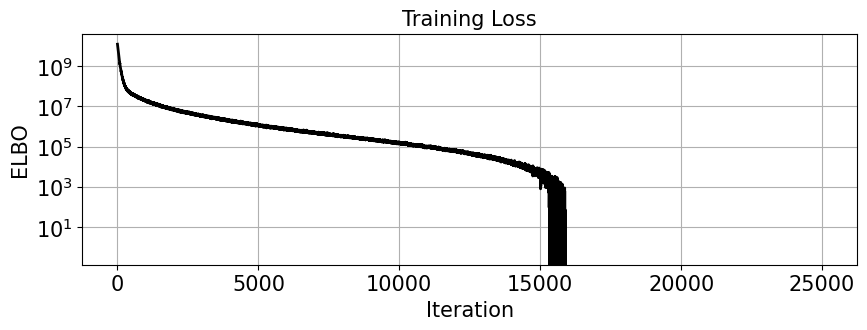

In [17]:
# %% Visualization
visualizations.plot_loss(
    [guide.losses],xlabel='Iteration',ylabel='ELBO',titlestr='Training Loss',colors=['k'],
)

In [20]:
with numpyro.handlers.seed(rng_seed=SEED):
    mu, Sigma, _ = posterior.sample(X_CONDITIONS)

visualizations.visualize_pc(
    mu[:,None],Sigma,pc=TEST_RESPONSE.reshape(TEST_RESPONSE.shape[0]*TEST_RESPONSE.shape[1],-1)
)

ValueError: Input X contains NaN.
PCA does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

# Compare covariance to emprircal

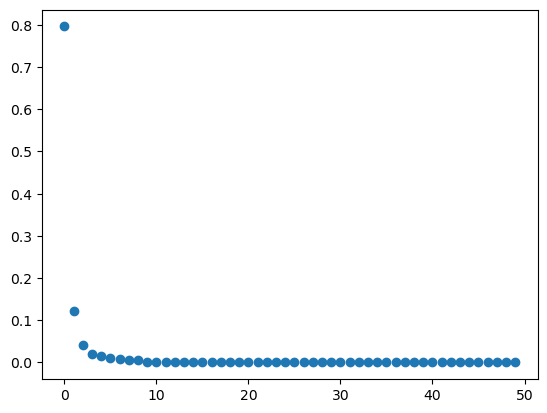

In [13]:
evals_store = np.zeros((12,50))
sigma_hat.shape
for iangle in range(12):
    cov_matrix = sigma_hat[iangle,:,:]
    eval, evec = np.linalg.eigh(cov_matrix)
    non_zero_evals = eval[::-1]
    evals_store[iangle,:] = non_zero_evals[:50]
    # plt.scatter(np.arange(len(non_zero_evals)), non_zero_evals)
    # plt.title(f'Angle {iangle}')
    # plt.show()
average_evals = np.mean(evals_store, axis=0)#[1:]
plt.scatter(np.arange(len(average_evals)), average_evals)





(0.0, 0.5)

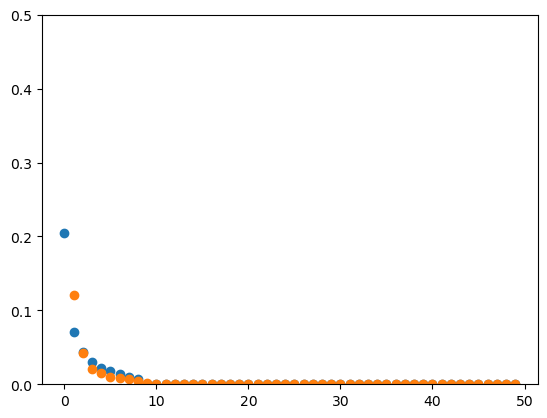

: 

In [ ]:
TEST_RESPONSE.shape
raw_evals_store = np.zeros((12,50))
for iangle in range(12):
    test = TEST_RESPONSE[:,iangle,:]  # shape (K, N)
    covariance_matrix = np.cov(test, rowvar=False)  # shape (N, N)
    eval, evec = np.linalg.eigh(covariance_matrix)
    non_zero_evals = eval[::-1]
    raw_evals_store[iangle,:] = non_zero_evals[:50]
average_raw_evals = np.mean(raw_evals_store, axis=0)#[1:]
plt.scatter(np.arange(len(average_raw_evals)), average_raw_evals)
plt.scatter(np.arange(len(average_evals)), average_evals)
plt.ylim(0,0.5)



In [ ]:
import pandas as pd
empirical_mu = jnp.nanmean(TEST_RESPONSE,axis=0)
print(empirical_mu.shape)
# empirical_cov =jnp.cov(TEST_RESPONSE,axis=0)
empirical_sigma = jnp.zeros((C, N, N))
for i in range(C):
    dat = TEST_RESPONSE[:,i,:] # Shape K x N
    df = pd.DataFrame(dat)
    covariances = df.cov().to_numpy()
    covariances += np.eye(N) * 1e-6
    empirical_sigma = empirical_sigma.at[i].set(covariances)
visualizations.visualize_pc(
    empirical_mu[:,None],empirical_sigma,pc=TEST_RESPONSE.reshape(TEST_RESPONSE.shape[0]*TEST_RESPONSE.shape[1],-1)
)
